<a href="https://colab.research.google.com/github/Loop3D/Kalgoorlie_3Dmodelling/blob/main/report_files_stratigraphy/01_B3_Model%20with%20all%20the%20data%20and%20no%20fold-frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files_stratigraphy
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural@v1.5.4
      !pip install lavavu-osmesa geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_data = r"./data"
path_DEM = r"./data/dem.tif"

In [4]:
updated_data = pd.read_csv(os.path.join(path_data, "LoopStructural_data/updated_data.csv"))
updated_oris = pd.read_csv(os.path.join(path_data, "LoopStructural_data/updated_oris.csv"))

In [5]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

# 1. Contacts

In [6]:
# Contact points file

contacts = gpd.read_file(os.path.join(path_data, "./contacts/contacts_altitude.shp"))

contacts = pd.DataFrame({'X': contacts.geometry.x, 
                          'Y': contacts.geometry.y, 
                          'Z': contacts['dem_2'], 
                          'name': contacts['name']})

contacts = contacts.dropna().reset_index()

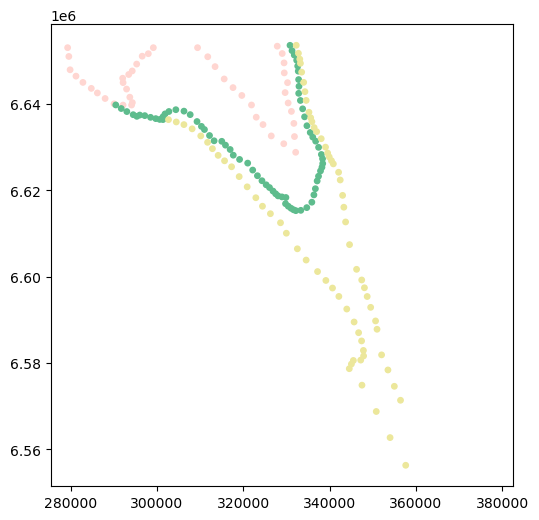

In [7]:
colores = {'Granitoids': '#ffd6d1', 'Mafics': '#5ebc8d', 'Black_Flag':'#ece79b'}
contacts["Color"] = contacts['name'].apply(lambda x: colores[x])
plt.figure(figsize = (10,6))
plt.scatter(data = contacts, x = 'X', y = 'Y', c='Color', s=15)
plt.axis('square');

# 2. Beddings

In [8]:
# bedding measurements file

beddings = gpd.read_file(os.path.join(path_data, "./beddings/beddings_0001_altitude.shp"))

beddings = pd.DataFrame({'X': beddings.geometry.x, 
                          'Y': beddings.geometry.y, 
                          'Z': beddings['DEM_main'], 
                          'name': 'Feat_name', 
                          'strike': beddings['STRIKE'], 
                          'dip': beddings['DIP'], 
                          'polarity' : 1, ### should be 1
                         })

# 3. Thicknesses

In [9]:
#thickness
thickness = {'Granitoids': 7000, 'Mafics': 3000, 'Black_Flag': 1500}

# 4. Stratigraphic order

In [10]:
#strati_order

order = [
    ("Group_1", [ "Black_Flag", "Mafics", "Granitoids"]), 
]

# 5. Model

In [11]:
processor = ProcessInputData(
    contacts=contacts,
    contact_orientations=beddings,
    thicknesses=thickness,
    stratigraphic_order=order,
    origin=origin,
    maximum=maximum, 
    fault_locations = updated_data, 
    fault_orientations = updated_oris
)

C:\Users\angel\anaconda3\envs\loopster\lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


In [12]:
model = GeologicalModel(processor.origin, processor.maximum)
model.data = processor.data
model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 

# model.nsteps = [100, 100, 100]
model.stratigraphic_column = processor.stratigraphic_column

model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])

model.create_and_add_fault('Black Flag Fault', displacement = 5000, nelements=1e4, force_mesh_geometry = False)

tang1 = np.tile([-1737.07, -2023.51,  7009.83],
                (model['Black Flag Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Black Flag Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Black Flag Fault'][0].interpolator.support.barycentre,
                vector = tang1, w=1, B=0)

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, 
                           regularization = [5,5,5])

model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Black Flag Fault'].add_abutting_fault(model['Boorara Fault'])
model['Black Flag Fault'].add_abutting_fault(model['Zuleika Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])


model.create_and_add_foliation("Group_1", nelements = 1e4, damp=True)

# solver - lu, chol, cg, lsqr, pyamg
# interpolatortype - FDI, PLI
# cgw=0.03
# buffer=0.3
# damp = True, F

model.update()

  0%|          | 0/13 [00:00<?, ?it/s]


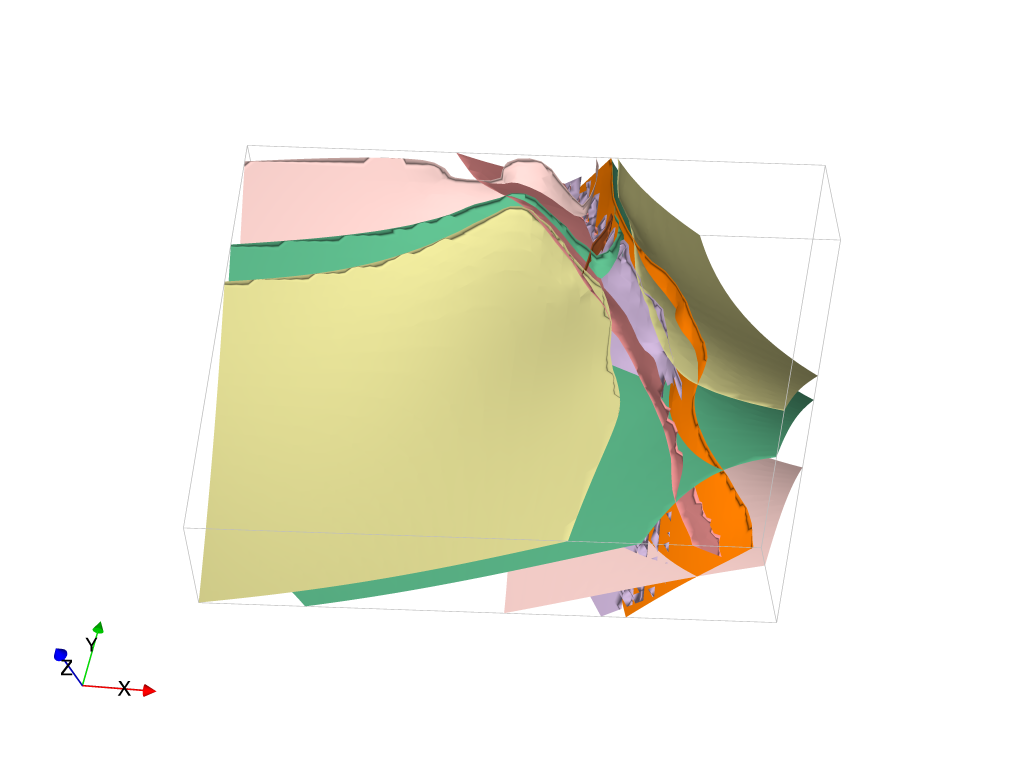

In [14]:
view = LavaVuModelViewer(model, kwargs ={'near':4862071, 'far': 2001})

# view.nelements = 4e6
all_names = []
all_values = []
colores = [['#ffd6d1'], ['#5ebc8d'], ['#ece79b']]

for n, vals in model.stratigraphic_column['Group_1'].items():
    all_names.append(n)
    all_values.append(vals['min'])
    
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_1'], value = valuey, 
                        colours = colores[i], 
                        names = [all_names[i]])

view.add_isosurface(model['Black Flag Fault'], colours = ['#b15928'], value = 0)#, function = export_verts_tris)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)#, function = export_verts_tris)
view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)#, function = export_verts_tris)
view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
# view.add_data(model['Group_1'])

view.rotation = [-36.52445983886719, -10.263699531555176, -1.9713062047958374]
view.display()
# view.interactive()

In [37]:
# with cgw

model = GeologicalModel(processor.origin, processor.maximum)
model.data = processor.data
model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 

model.stratigraphic_column = processor.stratigraphic_column

model.create_and_add_fault('Zuleika Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, cpw = .05)
model.create_and_add_fault('Boorara Fault', displacement = 5, nelements=1e4, force_mesh_geometry = True, 
                           cpw = 0.2, regularisation = [5, 5, 5])

model.create_and_add_fault('Black Flag Fault', displacement = 5000, nelements=1e4, force_mesh_geometry = False)

tang1 = np.tile([-1737.07, -2023.51,  7009.83],
                (model['Black Flag Fault'][0].interpolator.support.barycentre.shape[0],1))

model['Black Flag Fault'][0].interpolator.add_gradient_orthogonal_constraints(
                model['Black Flag Fault'][0].interpolator.support.barycentre,
                vector = tang1, w=1, B=0)

model.create_and_add_fault('Boulder Lefroy Fault', displacement = 5, nelements=1e4, force_mesh_geometry = False, 
                           regularization = [5,5,5])

model['Boulder Lefroy Fault'].add_abutting_fault(model['Boorara Fault'])
model['Black Flag Fault'].add_abutting_fault(model['Boorara Fault'])
model['Black Flag Fault'].add_abutting_fault(model['Zuleika Fault'])
model['Zuleika Fault'].add_abutting_fault(model['Boorara Fault'])


model.create_and_add_foliation("Group_1", nelements = 1e4, damp=True, cwg = 1.5)

# solver - lu, chol, cg, lsqr, pyamg
# interpolatortype - FDI, PLI
# cgw=0.03
# buffer=0.3
# damp = True, F

model.update()

  0%|          | 0/13 [00:00<?, ?it/s]


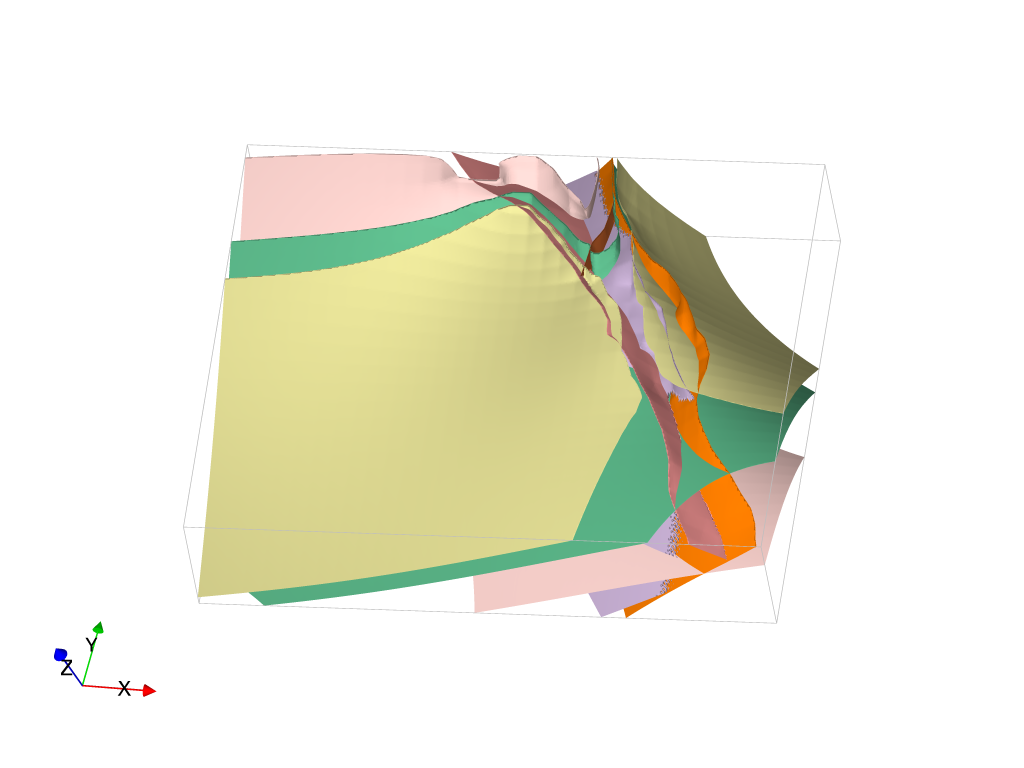

In [38]:
view = LavaVuModelViewer(model, kwargs ={'near':4862071, 'far': 2001})

view.nelements = 4e6
all_names = []
all_values = []
colores = [['#ffd6d1'], ['#5ebc8d'], ['#ece79b']]

for n, vals in model.stratigraphic_column['Group_1'].items():
    all_names.append(n)
    all_values.append(vals['min'])
    
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_1'], value = valuey, 
                        colours = colores[i], 
                        names = [all_names[i]])

view.add_isosurface(model['Black Flag Fault'], colours = ['#b15928'], value = 0)#, function = export_verts_tris)
view.add_isosurface(model['Boorara Fault'], colours = ['#ff7f00'], value = 0)#, function = export_verts_tris)
view.add_isosurface(model['Boulder Lefroy Fault'], colours = ['#cab2d6'], value = 0)#, function = export_verts_tris)
view.add_isosurface(model['Zuleika Fault'], colours = ['#fb9a99'], value = 0)
# view.add_data(model['Group_1'])

view.rotation = [-36.52445983886719, -10.263699531555176, -1.9713062047958374]
view.display()
# view.interactive()